In [2]:
import pandahouse as ph
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import hashlib

In [5]:
params = {
    'axes.edgecolor': 'gray',
    'figure.figsize': [8, 6]}
plt.rcParams.update(params)

In [6]:
connection = {
    'host': host,
    'password': password,
    'user': user,
    'database': database'
}

## A/B тестирование

## Задача 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 3 использовалась в качестве контроля. Эксперимент проходил с 2023-01-01 по 2023-01-07 включительно. <br>
Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. <br>
Задача — проанализировать данные АB-теста. Написать рекомендацию, стоит ли раскатывать алгоритм на всех пользователей

Проверим гипотезу несколькими методами:
- t-тест, 
- Пуассоновский бутстреп, 
- тест Манна-Уитни, 
- t-тест на сглаженном ctr (α=5),
- t-тест и тест Манна-Уитни поверх бакетного преобразования.

### A/A тест

проверим, нне было ли статзанчимых различий в выборках до проведения эксперимента

In [84]:
q0 = """
SELECT exp_group,
        user_id,
        sum(action='like') as likes,
        sum(action='view') as views,
        likes/ views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) BETWEEN toDate('2022-12-25') AND toDate('2022-12-31')
    AND exp_group IN (2, 3)
GROUP BY exp_group, user_id
    """

df0 = ph.read_clickhouse(q0, connection=connection)

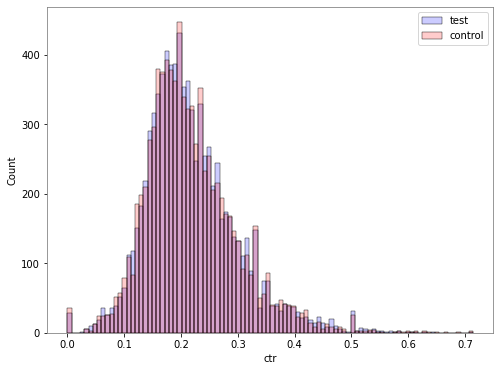

In [85]:
# посмотрим визуально, насколько различаются распределение ctr в группах

sns.histplot(data=df0, x='ctr', hue='exp_group', palette=['red', 'blue'], alpha=0.2, kde=False)
plt.legend(['test', 'control'])
plt.show()

In [86]:
# запускаем цикл на 10000 итераций: случайно выбираем 500 пользователей из группы без возвращения, проводим t-test
p_values = []
for i in range(10000):
    exp_group_2 = df0[df0['exp_group'] == 2]['ctr'].sample(500, replace=False)
    exp_group_3 = df0[df0['exp_group'] == 3]['ctr'].sample(500, replace=False)
    t_test_res = stats.ttest_ind(exp_group_2, exp_group_3, equal_var=False)            
    p_values.append(t_test_res[1])
    

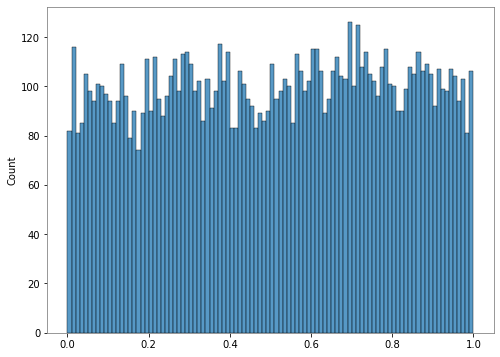

In [87]:
# рисуем гистограмму распределения p-values: распределение p-values похоже на равномерное

sns.histplot(data=p_values, bins=100)

plt.show()

In [89]:
# посчитаем % p-values, значения которых <= 0.05

sum([x <= 0.05 for x in p_values]) / len(p_values)

0.0469

*Вывод*: Из 10000 экспериментов только в 4,69% случаев p-value меньше 0.05. Это говорит о том, что на уровне значимости 5% мы можем принять нулевую гипотезу о равенсте ctr групп 2 и 3 и предположение, что статистически значимые различия между двумя группами встречаются только в результате случайного ложного срабатывания.
Таким образом можем использовать эти группы для проведения эксперимента.

### A/B тест

In [23]:
q = """
SELECT exp_group,
        user_id,
        sum(action='like') as likes,
        sum(action='view') as views,
        likes/ views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) BETWEEN toDate('2023-01-01') AND toDate('2023-01-07')
    AND exp_group IN (2, 3)
GROUP BY exp_group, user_id
    """
df = ph.read_clickhouse(q, connection=connection)


In [24]:
# пользователи распределены приблизительно равномерно

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,9952,9952,9952,9952
3,10049,10049,10049,10049


In [28]:
# создадим выборки по группам

group_test = df[df['exp_group'] == 2].drop(['likes', 'views'], axis=1)
group_control = df[df['exp_group'] == 3].drop(['likes', 'views'], axis=1)

mean_test:  0.21 mean_control:  0.23
median_test:  0.14 median_control:  0.22


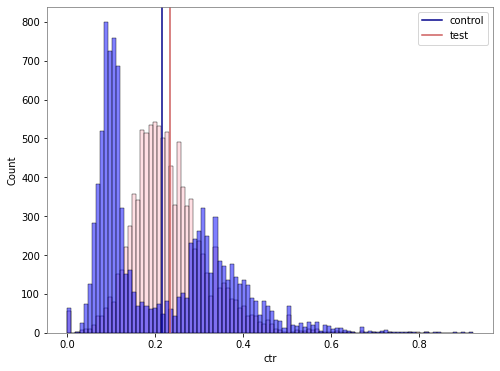

In [63]:
# при визуальной оценке рапределение группы 2 очень скошено право, при этом бимодальное. Это значит, точно нельзя делать t-test
# группа 1 распределена более-менее нормально, при этом групповые средние почти совпадают

print('mean_test: ', group_test['ctr'].mean().round(2), 'mean_control: ', group_control['ctr'].mean().round(2))
print('median_test: ', group_test['ctr'].median().round(2), 'median_control: ', group_control['ctr'].median().round(2))

sns.histplot(data=df, x='ctr', hue='exp_group', palette=['blue', 'pink'], alpha=0.5, bins=100)
plt.axvline(group_test['ctr'].mean(), color='darkblue')
plt.axvline(group_control['ctr'].mean(), color='indianred')

plt.legend(['control', 'test'])
plt.show()


In [30]:
# сохраним для анализа id юзеров, у которых ctr меньше среднего и больше среднего

users_sad = df[(df['exp_group'] == 2) & (df['ctr'] < group_test['ctr'].mean())]['user_id'].to_list()
users_happy = df[(df['exp_group'] == 2) & (df['ctr'] > group_test['ctr'].mean())]['user_id'].to_list()

In [31]:
len(users_sad), len(users_happy)

(5620, 4332)

## Тест Манна-Уитни

In [32]:
# Проверим расчетные ctr на тесте Манна-Уитни

# H0: P(group_test > group_control) = P(group_control > group_test)
# H1: P(group_test > group_control) != P(group_control > group_test)
# Критерий: Манна-Уитни
# Уровень значимости: 0.05
# Результат: p-val < 0.05
# Вывод: отвергаем H0, принимаем нипотезу, вероятности получить значения в одной группе больше, чем в другой равны, 
# то есть значения в группах отличаюся значимо

mann_test = stats.mannwhitneyu(group_test['ctr'], group_control['ctr'], alternative='two-sided')
mann_test

MannwhitneyuResult(statistic=41051053.0, pvalue=1.4033850708193012e-106)

## Сглаженный CTR

Метод используется, чтобы нивеоировать аномальные значения, возникшие у пользователей с низким количеством просмотров/лайков

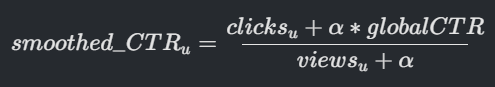

In [37]:
# расчитаем глобальные ctr для каждой группы

global_ctr_2 = df[df['exp_group'] == 2]['likes'].sum() / df[df['exp_group'] == 2]['views'].sum()
global_ctr_3 = df[df['exp_group'] == 3]['likes'].sum() / df[df['exp_group'] == 3]['views'].sum()

In [38]:
#  функция расчета сглаженного ctr
def get_smooth_ctr(likes, views, global_ctr, alpha=0):
    smooth_ctr = (likes + alpha * global_ctr) / (views + alpha)
    
    return smooth_ctr

In [39]:
# добавим колонки со сглаженным ctr
group_test['smooth_ctr'] = df.apply(lambda x: get_smooth_ctr(x['likes'], x['views'], global_ctr_2, alpha=5), axis=1)
group_control['smooth_ctr'] = df.apply(lambda x: get_smooth_ctr(x['likes'], x['views'], global_ctr_3, alpha=5), axis=1)


mean_test:  0.21 mean_control:  0.23
median_test:  0.15 median_control:  0.22


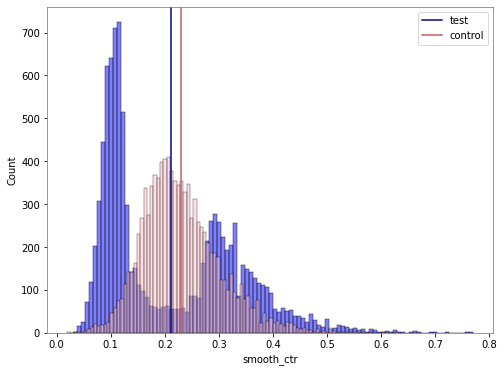

In [64]:
# посмотрим, как изменилось распределение при сглаженном ctr
# кардинально разброс в данных остался таким же

print('mean_test: ', group_test['smooth_ctr'].mean().round(2), 'mean_control: ', group_control['smooth_ctr'].mean().round(2))
print('median_test: ', group_test['smooth_ctr'].median().round(2), 'median_control: ', group_control['smooth_ctr'].median().round(2))

sns.histplot(data=group_test, x='smooth_ctr', alpha=0.5, bins=100, color='blue')
sns.histplot(data=group_control, x='smooth_ctr', alpha=0.5, bins=100, color='pink')
plt.axvline(group_test['smooth_ctr'].mean(), color='darkblue')
plt.axvline(group_control['smooth_ctr'].mean(), color='indianred')
plt.legend(['test', 'control'])
plt.show()

In [65]:
# Проверим сглаженные ctr на тесте Манна-Уитни

# H0: P(group_test > group_control) = P(group_control > group_test)
# H1: P(group_test > group_control) != P(group_control > group_test)
# Критерий: Манна-Уитни
# Уровень значимости: 0.05
# Результат: p-val < 0.05. 
# Вывод: отвергаем H0, принимаем нипотезу, вероятности получить значения в одной группе больше, чем в другой равны, 
# то есть значения в группах отличаюся значимо

mann_test = stats.mannwhitneyu(group_test['smooth_ctr'], group_control['smooth_ctr'], alternative='two-sided')
mann_test

MannwhitneyuResult(statistic=40399469.0, pvalue=2.3341322073006608e-122)

## Пуассоновский бутсреп

In [81]:
# формируем массивы значений лайков и просмотров по обеим группам

likes2 = df[df['exp_group'] == 2]['likes'].to_numpy() 
likes3 = df[df['exp_group'] == 3]['likes'].to_numpy()
views2 = df[df['exp_group'] == 2]['views'].to_numpy() 
views3 = df[df['exp_group'] == 3]['views'].to_numpy() 

def bootstrap(likes2, likes3, views2, views3, n_bootstrap=2000):
    # формируем веса для каждого значение
    poisson_boost2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    poisson_boost3 = stats.poisson(1).rvs((n_bootstrap, len(likes3))).astype(np.int64)
    
    # считаем глобальные ctr по группам
    glob_ctr2 = (poisson_boost2 * likes2).sum(axis=1) / (poisson_boost2 * views2).sum(axis=1)
    glob_ctr3 = (poisson_boost3 * likes3).sum(axis=1) / (poisson_boost3 * views3).sum(axis=1)
    
    return glob_ctr2, glob_ctr3

In [82]:
# считаем ctr по бутстрэп выборкам

ctr2, ctr3 = bootstrap(likes2, likes3, views2, views3)

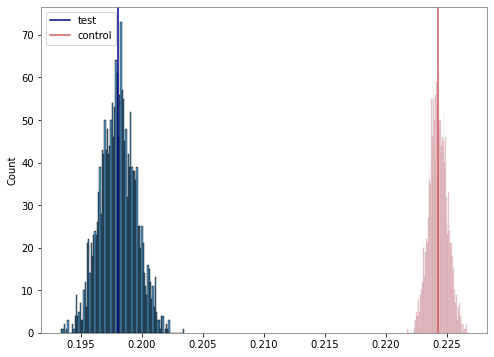

In [83]:
# на графике видно, что распределения очень далеки друг от друга, причем у контрольной группы ctr выше

sns.histplot(ctr2, bins=100, label='2')
sns.histplot(ctr3, color='pink', bins=100, label='3')
plt.axvline(ctr2.mean(), color='darkblue')
plt.axvline(ctr3.mean(), color='indianred')

plt.legend(['test', 'control'])
plt.show()

## Бакетное преобразование

In [76]:
q2 = """
SELECT exp_group, 
        bucket,
        sum(likes) / sum(views) as bucket_ctr
FROM (
    SELECT exp_group,
            xxHash64(user_id)%50 as bucket,
            user_id,
            sum(action='like') as likes,
            sum(action='view') as views,
            likes/views as ctr
    FROM {db}.feed_actions
    WHERE toDate(time) BETWEEN toDate('2023-01-01') AND toDate('2023-01-07')
                        AND exp_group IN (2, 3)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

In [77]:
df2 = ph.read_clickhouse(q2, connection=connection)

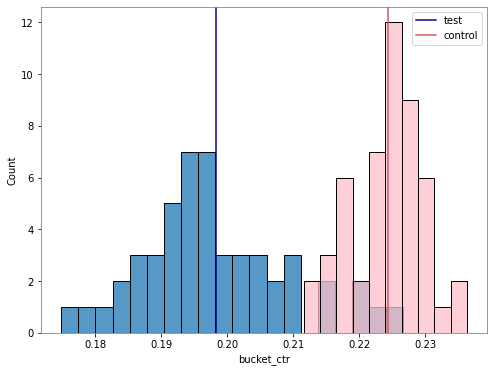

In [78]:
# как видно на графике, распредеоения групповых ctr сдвинуты относительно друг друга, причем тестовая группа левее, 
# то есть, ее значения меньше. проверим это на тесте ниже

sns.histplot(df2[df2['exp_group'] == 2]['bucket_ctr'], bins=20)
sns.histplot(df2[df2['exp_group'] == 3]['bucket_ctr'], color='pink', bins=10)
plt.axvline(df2[df2['exp_group'] == 2]['bucket_ctr'].mean(), color='darkblue')
plt.axvline(df2[df2['exp_group'] == 3]['bucket_ctr'].mean(), color='indianred')

plt.legend(['test', 'control'])
plt.show()

In [80]:
# H0: P(group_test > group_control) = P(group_control > group_test)
# H1: P(group_test > group_control) != P(group_control > group_test)
# Критерий: Манна-Уитни
# Уровень значимости: 0.05
# Результат: p-val > 0.05. 
# Вывод: отвергаем H0, принимаем нипотезу, вероятности получить значения в одной группе больше, чем в другой равны, 
# то есть значения в группах отличаюся значимо

mann_test = stats.mannwhitneyu(df2[df2['exp_group'] == 2]['bucket_ctr'], df2[df2['exp_group'] == 3]['bucket_ctr'], alternative='two-sided')
mann_test

MannwhitneyuResult(statistic=73.0, pvalue=5.037908645567343e-16)

## Промежуточный вывод

Эффект от нововведения получился неоднозначным - так как для части пользователей ctr изменился в худшую сторону, а для части - в лучшую. При этом плохого эффекта больше, это хорошо видно на всех графиках - изначальном ctr, пуассоновском бустрэпе и анализе через бакетное преобразование. <br>

Посмотрим, как изменялось распределение лайков и просмотов у польщователей тестовой группы. Для этого будем условно поделим ее на две группы - "грустная" (ctr ниже средней) и "счастливая" (ctr выше средней)

In [90]:
q3 = """
SELECT toDate(time) as time,
        user_id,
        sum(action='like') as likes,
        sum(action='view') as views
FROM {db}.feed_actions 
WHERE toDate(time) BETWEEN toDate('2023-01-01') AND toDate('2023-01-07')
    AND exp_group = 2
GROUP BY time, user_id
    """
df2 = ph.read_clickhouse(q3, connection=connection)

In [91]:
# создадим датасеты юзеров, поделенных по уровню ctr

df_sad = df2[df2['user_id'].isin(users_sad)].sort_values(by='time')
df_happy = df2[df2['user_id'].isin(users_happy)].sort_values(by='time')

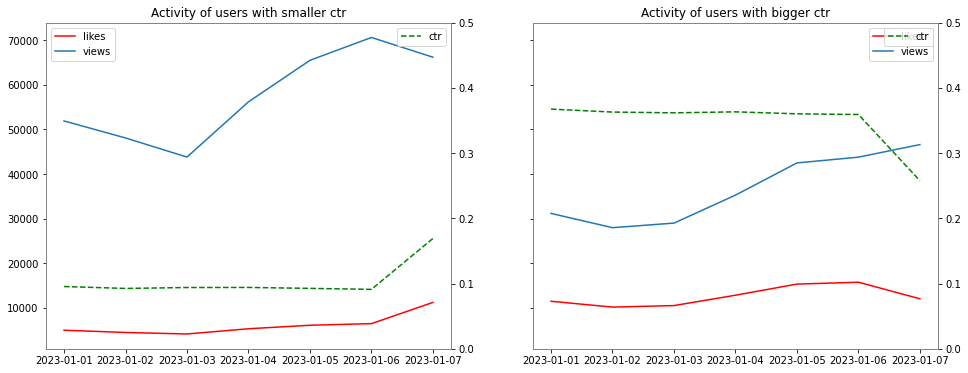

In [92]:
# посмотрим, как изменялось их поведение со временем
# на графике видно, что большая часть учеличения ctr обусловлена падением просмотров, а не ростом количества лайков

df_sad_plot = df_sad.groupby('time', as_index=False)[['likes', 'views']].sum()
df_happy_plot = df_happy.groupby('time', as_index=False)[['likes', 'views']].sum()

fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(16, 6)

ax[0].plot(df_sad_plot['time'], df_sad_plot['likes'], color='red')
ax[0].plot(df_sad_plot['time'], df_sad_plot['views'])
ax[0].legend(['likes', 'views'])
ax[0].set_title('Activity of users with smaller ctr')
axc0 = ax[0].twinx()
axc0.plot(df_sad_plot['time'], df_sad_plot['likes']/df_sad_plot['views'], '--g')
axc0.legend(['ctr'], loc='upper right')
axc0.set_ylim(0, 0.5)
# axc0.autoscale()

ax[1].plot(df_happy_plot['time'], df_happy_plot['likes'], color='red')
ax[1].plot(df_happy_plot['time'], df_happy_plot['views'])
ax[1].legend(['likes', 'views'])
ax[1].set_title('Activity of users with bigger ctr')
axc1 = ax[1].twinx()
axc1.plot(df_happy_plot['time'], df_happy_plot['likes'] / df_happy_plot['views'], '--g')
axc1.legend(['ctr'], loc='upper right')
axc1.set_ylim(0, 0.5)


plt.show() 

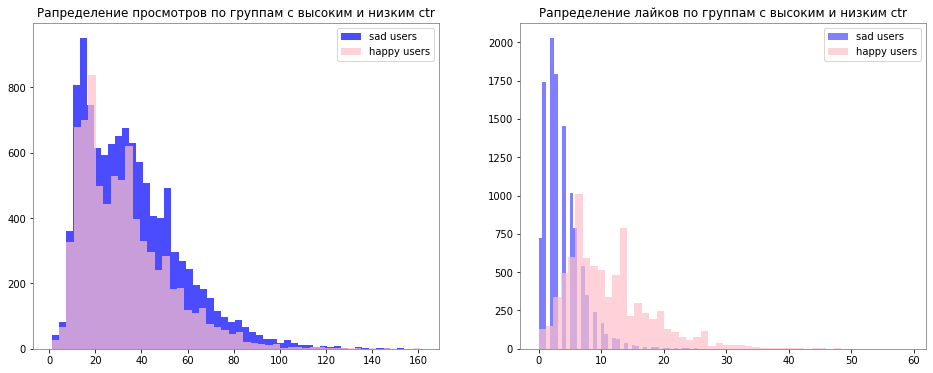

In [93]:
# посмотрим, как распределелялись лайки и просмотры по частоте в обеих группах
#  на графиках видно, что распределение просмотров очень похожи, но просмотров в "грустной" группе (низкий ctr) явно больше, 
# чем в счастливой (высокий ctr)
# распределение лайков же имеет гораздо более различимый характер
# проверим на стат.тестах разницу в выборках по лайкам и просмотрам

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 6)


ax[0].hist(df_sad['views'], color='blue', alpha=0.7, bins=50, label='sad users')
ax[0].hist(df_happy['views'], color='pink', alpha=0.7, bins=50, label='happy users')
ax[0].legend()
ax[0].set_title('Рапределение просмотров по группам с высоким и низким ctr')

ax[1].hist(df_sad['likes'], color='blue', alpha=0.5, bins=50, label='sad users')
ax[1].hist(df_happy['likes'], color='pink', alpha=0.7, bins=50, label='happy users')
ax[1].legend()
ax[1].set_title('Рапределение лайков по группам с высоким и низким ctr')



plt.show()

In [94]:
# Проверим первую гипотезу о разности распределений просмотров

# H0: средняя величина распределения просмотов у группы с низким ctr такая же, как у группы с высоким ctr
# H1: средняя величина распределения просмотов у группы с низким ctr выше, чем у группы с высоким ctr
# Критерий: t-критерий Стьюдента, u-критерий Манна-Уитни
# Уровень значимости: 0.05
# Результат: p-val > 0.05 для обоих тестов. 
# Вывод: отвергаем H0, о равенстве средних, т.о. приинимаем гипотезц, что среднее кол-во просмотров в "грустной" группе выше

stats.ttest_ind(df_sad['views'], df_happy['views'], equal_var=False, alternative='greater'),\
stats.mannwhitneyu(df_sad['views'], df_happy['views'], alternative='greater')

(Ttest_indResult(statistic=12.211740895518107, pvalue=1.8341298441290196e-34),
 MannwhitneyuResult(statistic=48748312.0, pvalue=1.2741530606834328e-29))

In [95]:
# Проверим первую гипотезу о разности распределений просмотров

# H0: средняя величина распределения лайков у группы с низким ctr такая же, как у группы с высоким ctr
# H1: средняя величина распределения лайков у группы с низким ctr ниже, чем у группы с высоким ctr
# Критерий: t-критерий Стьюдента, u-критерий Манна-Уитни
# Уровень значимости: 0.05
# Результат: p-val = 0 для обоих тестов, т.о. верроятность H0=0
# Вывод: отвергаем H0, о равенстве средних, т.о. среднее кол-во лайков в "грустной" группе ниже, чем у "счастливой"

stats.ttest_ind(df_sad['likes'], df_happy['likes'], equal_var=False, alternative='less'),\
stats.mannwhitneyu(df_sad['likes'], df_happy['likes'], alternative='less')

(Ttest_indResult(statistic=-89.28789947144992, pvalue=0.0),
 MannwhitneyuResult(statistic=11704620.0, pvalue=0.0))

In [96]:
# проверим гипотезу, что лайков в "счастливой" группе количество лайков все равно меньше, чем в изначально контрольной группе

# H0: средняя величина распределения лайков у "счатливой" группы такая же, как у контрольной группы
# H1: средняя величина распределения лайков у "счатливой" группы ниже, чем у контрольной группы 
# Критерий: t-критерий Стьюдента, u-критерий Манна-Уитни
# Уровень значимости: 0.05
# Результат: p-val Б 0.05 для обоих тестов, 
# Вывод: отвергаем H0, о равенстве средних, т.о. среднее кол-во лайков у "счатливой" группы ниже, чем у контрольной группы

stats.ttest_ind(df_happy['likes'], df['likes'], equal_var=False, alternative='less'),\
stats.mannwhitneyu(df_happy['likes'], df['likes'], alternative='less')

(Ttest_indResult(statistic=-26.81861102094981, pvalue=2.1752939837594994e-156),
 MannwhitneyuResult(statistic=71424420.0, pvalue=2.913060234306159e-39))

### Выводы

Более подробный анализ польователей тестовой группы показал, что она условно разделилась на два кластера: 
-первая группа (ctr ниже средней по группе)  совершила больше просмотров, но при этом меньше лайков <br>
-вторая группа(ctr выше средней по группе) совершила меньше просмотров, но при этом больше лайков.<br>

Таким образом, рост ctr был обусловлен отчасти тем, что упали просмотры, а не тем, что выросли лайки. То есть, пользователи первой группы заходили чаще, но им не нравился контент и они его не лайкали, а на пользователи второй группы стали заходить реже, но лайкать в привычном режиме. Эти гипотезы можно проверить более глубоким исследование  - например, сравнив "вторую группу" с контрольной и посмотреть, как изменились метрики относительно нее.